In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import imutils
from skimage.filters import threshold_local
import keras 
from keras import optimizers
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import Sequential

In [ ]:
os.listdir('drive/My Drive/Colab Notebooks/Number Plate/')

## Prepare Data

In [3]:
!unzip -q 'drive/My Drive/Colab Notebooks/Number Plate/car_long' -d car_long

In [4]:
image_path = os.listdir("./car_long/car_long/")
list_image_path = []
for i in image_path:
  list_image_path.append(os.path.join("./car_long/car_long/",i))
print(len(list_image_path))

1000


In [5]:
ALPHA_DICT = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P',
              13: 'R', 14: 'S', 15: 'T', 16: 'U', 17: 'V', 18: 'X', 19: 'Y', 20: 'Z', 21: '0', 22: '1', 23: '2', 24: '3',
              25: '4', 26: '5', 27: '6', 28: '7', 29: '8', 30: '9', 31: "Background"}

## Detect number plate

In [7]:
def detect(image):
  (H, W) = image.shape[:2]
  # prepare for dectect 
  weight_path = 'drive/My Drive/Colab Notebooks/Number Plate/yolov3-tiny_15000.weights'
  cfg_path = 'drive/My Drive/Colab Notebooks/Number Plate/cfg/yolov3-tiny.cfg'
  blob = cv2.dnn.blobFromImage(image, 1 / 255.0, size=(416, 416), swapRB=True, crop=False)
  model = cv2.dnn.readNetFromDarknet(cfg_path, weight_path)

  layersNames = model.getLayerNames()
  ln = [layersNames[i[0] - 1] for i in model.getUnconnectedOutLayers()]

  # detect
  model.setInput(blob)
  outputs = model.forward(ln)
  
  # process outputs 
  boxes = []
  confidences = []
  classIDs = []
  confidence = 0.5
  threshold = 0.5
  for output in outputs:
	  for detection in output:
		  scores = detection[5:]
		  classID = np.argmax(scores)
		  confidence = scores[classID]
		  if confidence > 0.5:
			  box = detection[0:4] * np.array([W, H, W, H])
			  (centerX, centerY, width, height) = box.astype("int")
			  x = int(centerX - (width / 2))
			  y = int(centerY - (height / 2))
			  boxes.append([x, y, int(width), int(height)])
			  confidences.append(float(confidence))
			  classIDs.append(classID)
  idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)
  coordinates = []
  licensePlates = []
  if len(idxs) > 0:
	  for i in idxs.flatten():
		  (x, y) = (boxes[i][0], boxes[i][1])
		  (w, h) = (boxes[i][2], boxes[i][3])
		  coordinates.append([x,y,w,h])
    
  for coordinate in coordinates :
    (x,y,w,h) = coordinate[0], coordinate[1], coordinate[2], coordinate[3]
    lpNumber = image[y:y+h, x:x+w].copy()
    licensePlates.append(lpNumber)
  return coordinates, licensePlates

## Detect digit region

In [37]:
def segmentation(LpRegion):
  ##### LPRegion Preprocess ###########
  # apply thresh to extracted licences plate
  V = cv2.split(cv2.cvtColor(LpRegion, cv2.COLOR_BGR2HSV))[2]
  # adaptive threshold
  T = threshold_local(V, 15, offset=10, method="gaussian")
  thresh = (V > T).astype("uint8") * 255
  # convert black pixel of digits to white pixel
  thresh = cv2.bitwise_not(thresh)
  thresh = imutils.resize(thresh, width=400)
  thresh = cv2.medianBlur(thresh, 5)

  # plt.imshow(thresh,cmap='gray')
  # plt.show()
  ######## Countours Number ############
  # find number
  digit_coordinates = []
  digitImages = []
  cont,hier = cv2.findContours(thresh.copy(),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
  for ind,cnt in enumerate(cont) :
    (x, y, w, h) = cv2.boundingRect(cnt)
    aspectRatio = w / h
    solidity = cv2.contourArea(cnt) / float(w * h)
    heightRatio = h / float(thresh.shape[0])
    if 0 < aspectRatio < 1.0 and solidity > 0.2 and 0.2 < heightRatio < 2.0 :
      digit_coordinates.append([x,y,w,h])
  
  ######### Crop DiGit ############
  for digitCoordinate in digit_coordinates: 
    x,y,w,h = digitCoordinate[0], digitCoordinate[1], digitCoordinate[2], digitCoordinate[3]
    digit = thresh[y:y+h, x:x+w].copy()
    if len(digit) > 0 :
      digit = cv2.resize(digit,(28,28))
      digitImages.append(digit)
  return digit_coordinates, digitImages

# Classification digit

In [38]:
class CNN_Model(object):
    def __init__(self, trainable=True):
        self.batch_size = 128
        self.trainable = trainable
        self.num_epochs = 50
        # Building model
        self._build_model()
        # Input data
        if trainable:
            self.model.summary()
            # self.data = Datasets()
        self.model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(1e-3), metrics=['acc'])

    def _build_model(self):
        # CNN model
        self.model = Sequential()
        self.model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
        self.model.add(Conv2D(64, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(32, activation='softmax'))
charRecog = CNN_Model(trainable=False).model
charRecog.load_weights('drive/My Drive/Colab Notebooks/Number Plate/weight.h5')

In [39]:
def recognizeChar(model, digitList):
  totalDigit = []
  for character in digitList :
    character = np.array(character)
    character = np.reshape(character,(1,28,28,1))
    result = model.predict_on_batch(character)
    result_idx = np.argmax(result, axis=1)
    totalDigit.append(result_idx)
  return totalDigit

#Support fuction

## Show 

In [8]:
def showDigitRegion(image, license_coordinate, digit_coordinates):
  x_plate, y_plate, w_plate, h_plate = license_coordinate[0], license_coordinate[1], license_coordinate[2], license_coordinate[3]
  LpRegion = image[y_plate:y_plate+h_plate,x_plate:x_plate+w_plate].copy()
  LpRegion = imutils.resize(LpRegion, width=400)
  for coordinate in digit_coordinates:
    (x,y,w,h) = coordinate[0], coordinate[1], coordinate[2], coordinate[3]
    cv2.rectangle(LpRegion,(x,y),(x+w,y+h),(0,255,0),2)
  plt.imshow(cv2.cvtColor(LpRegion,cv2.COLOR_BGR2RGB))
  plt.show()

In [6]:
def show_detect_image(image, coordinates):
  tmp_im = image.copy()
  for i in coordinates:
    x, y, w, h = i[0], i[1], i[2], i[3]
    cv2.rectangle(tmp_im,(x,y),(x+w,y+h), (0,255,0), 2)
  plt.imshow(tmp_im)
  plt.show()

## Sort Digit

In [12]:
def sortCoordinates(digitCoordinates, digitImages):
  listY = [ i[1] for i in digitCoordinates ]
  listX = [ i[0] for i in digitCoordinates ]
  listH = [ i[2] for i in digitCoordinates ]
  meanH = float(sum(listH)) / max(len(listH), 1)
  minY = min(listY)
  digitDict = []
  numOfLevel1 = 0
  for i,y in enumerate(listY):
    if  y < (minY + meanH) : 
      numOfLevel1 += 1
      digitDict.append({"index":i, "level": 1, "x" : listX[i], "y": y})
    else : 
      digitDict.append({"index":i, "level": 2, "x" : listX[i], "y": y})
  digitDict.sort(key = lambda e : e['level'])              ## sort by level
  level1Dict = digitDict[:numOfLevel1]
  level1Dict.sort(key = lambda e : e['x'])                 ## sort level1 by x
  level2Dict = digitDict[numOfLevel1:]
  level2Dict.sort(key = lambda e : e['x'])                 ## sort level2 by x
  digitDict = level1Dict + level2Dict     
  newDigitCoordinates = [] 
  newDigitImages = []
  for i,digit in enumerate(digitDict) : 
      newDigitCoordinates.append(digitCoordinates[digit['index']])
      newDigitImages.append(digitImages[digit['index']])
  return newDigitCoordinates, newDigitImages


## remove child box 

In [40]:
def detroyBoxInBox(digitCoordinates, digitImages):
  i = 0
  while i < len(digitCoordinates)-1:
    j = i+1
    while j < len(digitCoordinates) :
      x_prev, y_prev, w_prev, h_prev = digitCoordinates[i]
      x_next, y_next, w_next, h_next = digitCoordinates[j]
      if x_prev <= x_next and y_prev <= y_next and (x_prev + w_prev) >= (x_next + w_next) and (y_prev + h_prev) >= (y_next + h_next) : 
        digitCoordinates.remove(digitCoordinates[j])
        del digitImages[j]
        continue
      j += 1
    i += 1
  return digitCoordinates, digitImages

# Run

In [41]:
def Run(image_path):
  image = cv2.imread(image_path)
  coordinates, lpNumbers = detect(image)   ## detect lince plate
  digit_coordinates, digitImages = segmentation(lpNumbers[0])   ## detect digit box
  digit_coordinates, digitImages = sortCoordinates(digit_coordinates, digitImages) ## sort digit box
  digit_coordinates, digitImages = detroyBoxInBox(digitCoordinates= digit_coordinates, digitImages = digitImages)
  totalDigit = recognizeChar(charRecog,digitImages)

  show_detect_image(image,coordinates)

  plt.imshow(lpNumbers[0],cmap="gray")     ## show number plate image
  plt.show()

  showDigitRegion(image,coordinates[0],digit_coordinates)  

  plate = ""
  for i in totalDigit:
    if i <= 30 :
      plate = plate + str(format(ALPHA_DICT[i[0]]))
  print(plate)


# Test 

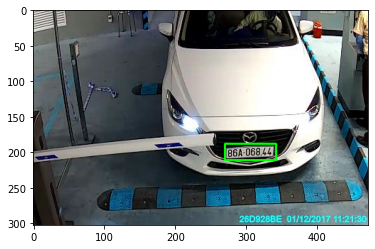

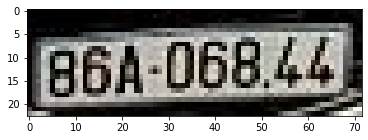

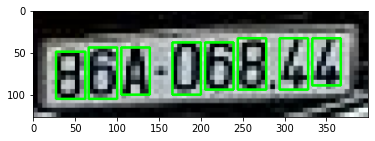

B5A06844


In [42]:
Run('./car_long/car_long/301.jpg')

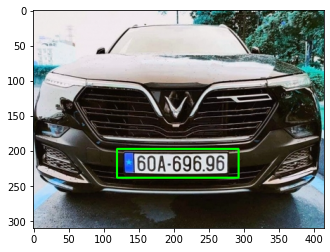

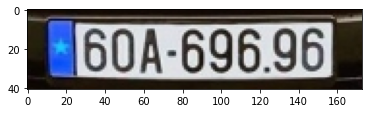

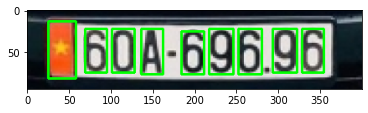

60A69696


In [43]:
Run('vinFast.jpg')